In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/2022_12_07_new_multilin_panel/")

In [2]:
# Helper functions
def pearson_corr_df_to_df(df1, df2):
    norm1 = df1 - df1.mean(axis=0)
    norm2 = df2 - df2.mean(axis=0)
    sqsum1 = (norm1**2).sum(axis=0)
    sqsum2 = (norm2**2).sum(axis=0)
    return((norm1.T @ norm2) / np.sqrt(sqsum1.apply(lambda x: x*sqsum2)))


def marker_finder(input_df, groups):
    """
    Function to find pearson correlation coefficient values and p-values for 
    the given data and groups for groups to test. The function will perform a 
    Pearson correlation of the input_df feature values to an "idealized" 
    group specific expression vector, where each observation in a given group
    is set to a value of 1, and the observations in other groups are set to 0.
    Arguments
    ---------
    input_df : pandas.DataFrame
        DataFrame with observations as index and features as columns (Required)
    
    groups : list[str]
        List-like of specified groups corresponding to observations from the 
        input_df. The order of groups should match the order in input_df.index
        (Required)
    Returns
    -------
    r_df
        a pandas.DataFrame containing the pearson
        correlation coefficient values for each marker to the idealized vector
        for each cluster.
    """
    ideal_vectors = pd.get_dummies(groups)
    ideal_vectors.index = input_df.index.values
    degrees_f = input_df.shape[0] - 2
    r_df = pearson_corr_df_to_df(input_df, ideal_vectors)
    # t_df = r_df*np.sqrt(degrees_f) / np.sqrt(1-(r_df**2))
    # p_df = t_df.applymap(lambda x: t.sf(abs(x), df=degrees_f)*2)
    return(r_df)

def map_min_max(input_array, input_min, input_max):
    tmp_scaler = 1 / (input_max - input_min)
    input_array = np.array(input_array)
    input_array[input_array < input_min] = input_min
    input_array[input_array > input_max] = input_max
    return(tmp_scaler * (np.array(input_array) - input_min))

In [3]:
### cellHarmony function 

def cellharmony(reference_adata, query_adata, obs_field, var_series,
        reference_npcs=30, query_npcs=30,
        reference_louvain_resolution=1, query_louvain_resolution=1,
        use_zscore=True):
    # Set up temporary variables for function
    ref_adata = reference_adata[:,var_series.index.values].copy()
    que_adata = query_adata[:,var_series.values].copy()
    ### Step 1: Define Communities
    print("\nStep 1: Defining Communities")
    ## Louvain Clustering
    # PCA
    print("\tRunning pca...")
    sc.tl.pca(ref_adata)
    sc.tl.pca(que_adata)

    plt.close("all")
    plt.plot(\
        list(range(1, 1+len(ref_adata.uns['pca']['variance_ratio']))),
        ref_adata.uns['pca']['variance_ratio'])
    plt.title("Reference PCA")
    plt.show()

    plt.close("all")
    plt.plot(\
        list(range(1, 1+len(que_adata.uns['pca']['variance_ratio']))),
        que_adata.uns['pca']['variance_ratio'])
    plt.title("Query PCA")
    plt.show()

    # Find Neighbors
    print("\tFinding neighbors...")
    sc.pp.neighbors(ref_adata, n_pcs=reference_npcs)
    sc.pp.neighbors(que_adata, n_pcs=query_npcs)

    # Louvain Clustering
    print("\tFinding Louvain communities...")
    sc.tl.louvain(ref_adata, resolution=reference_louvain_resolution)
    sc.tl.louvain(que_adata, resolution=query_louvain_resolution)

    ### Step 2: Find Closest Matching Communities
    print("\nStep 2: Find closest matching communities")
    # Normalize data by zscore if specified
    if use_zscore:
        ref_adata.X = zscore(ref_adata.X, axis=0)
        que_adata.X = zscore(que_adata.X, axis=0)

    # Generate Community Reference Centroids
    # Should total expression space be used, or is it better to use PCA space?
    ref_com_centroids = pd.DataFrame(\
        # ref_adata.obsm['X_pca'][:,:30], # PCA space
        ref_adata.X,
        index = ref_adata.obs.index.values,
        columns = ref_adata.var.index.values)
    ref_com_centroids["louvain"] = ref_adata.obs["louvain"].values
    ref_com_centroids = pd.pivot_table(\
        ref_com_centroids, 
        index="louvain", 
        aggfunc=np.mean)
    que_com_centroids = pd.DataFrame(\
        # que_adata.obsm['X_pca'][:,:30], # PCA space
        que_adata.X,
        index = que_adata.obs.index.values,
        columns = que_adata.var.index.values)
    que_com_centroids["louvain"] = que_adata.obs["louvain"].values
    que_com_centroids = pd.pivot_table(\
        que_com_centroids, 
        index="louvain", 
        aggfunc=np.mean)

    # Correlate community reference centroids
    # (query comes first, so it will be in rows of correlation matrix)
    com_correlations = pearson_corr_df_to_df(\
        que_com_centroids.T,
        ref_com_centroids.T)

    # Community matches
    com_matches = pd.DataFrame({\
            "ref_match": com_correlations.idxmax(axis=1),
            "rho": com_correlations.max(axis=1)},
        index=com_correlations.index.values)

    # Community matches to reference
    com_matches_ref = pd.DataFrame({\
            "que_match": com_correlations.idxmax(axis=0),
            "rho": com_correlations.max(axis=0)},
        index=com_correlations.columns.values)

    com_matches_dict = {}
    for tmp_que_com in com_matches.index.values:
        com_matches_dict[tmp_que_com] = [com_matches.loc[tmp_que_com, 
            "ref_match"]]

    for tmp_ref_com in com_matches_ref.index.values:
        tmp_que_com = com_matches_ref.loc[tmp_ref_com, "que_match"]
        if tmp_ref_com not in com_matches_dict[tmp_que_com]:
            com_matches_dict[tmp_que_com].append(tmp_ref_com)

    ### Step 3: Find Closest Matching Reference Cells in Communities
    print("\nStep 3: Find closest matching reference cells in communities")
    # Save correlation results
    top_cell_correlations = []

    for que_com in com_matches_dict:
        ref_coms = com_matches_dict[que_com]
        print("\tMatching query {} to reference {}...".format(que_com, ref_coms))
        # Get cells matching louvain communities
        tmp_que_cells = que_adata.obs.loc[\
            que_adata.obs["louvain"] == que_com].index.values
        tmp_ref_cells = ref_adata.obs.loc[\
            ref_adata.obs["louvain"].isin(ref_coms)].index.values
        # Get filtered data for matching reference communities
        que_filtered_data = pd.DataFrame(que_adata[tmp_que_cells,:].X, 
            columns=que_adata.var.index.values, 
            index=tmp_que_cells)
        ref_filtered_data = pd.DataFrame(ref_adata[tmp_ref_cells,:].X, 
            columns=ref_adata.var.index.values, 
            index=tmp_ref_cells)
        # Calculate cell-to-cell correlations
        tmp_cell_to_cell = pearson_corr_df_to_df(\
            que_filtered_data.T,
            ref_filtered_data.T)
        # com_com_correlations[que_com] = tmp_cell_to_cell # save memory, don't save
        # Get the top correlation for each query cell
        top_cell_correlations.append(pd.DataFrame({\
                "top_match": tmp_cell_to_cell.idxmax(axis=1),
                "rho": tmp_cell_to_cell.max(axis=1)},
            index=tmp_cell_to_cell.index.values))

    top_cell_correlations = pd.concat(top_cell_correlations)
    map_ref_cells_to_groups = pd.Series(\
        ref_adata.obs[obs_field].values,
        index=ref_adata.obs.index.values)
    top_cell_correlations["pred"] = [map_ref_cells_to_groups[item] for item in \
        top_cell_correlations["top_match"].values]

    ### Step 4: Generate centroids for predictions on query dataset
    print("\nStep 4: Generating centroids fro predictions on query dataset")
    que_pred_centroids = pd.DataFrame(\
        que_adata.X, 
        index=que_adata.obs.index.values,
        columns=que_adata.var.index.values)
    que_pred_centroids["new_index"] = top_cell_correlations.loc[\
        que_adata.obs.index.values,
        "pred"].values
    que_pred_centroids = pd.pivot_table(\
        que_pred_centroids, 
        index="new_index", 
        aggfunc=np.mean)

    ### Step 5: Generate new communities using centroid pearson correlation
    print("\nStep 5: Calculating final predictions")
    # Calculate cell-to-cell correlations
    tmp_cell_to_cell = pearson_corr_df_to_df(\
        que_pred_centroids.T,
        pd.DataFrame(\
            que_adata.X,
            index = que_adata.obs.index.values,
            columns = que_adata.var.index.values).T).T
    # com_com_correlations[que_com] = tmp_cell_to_cell # save memory, don't save
    # Get the top correlation for each query cell
    final_preds_df = pd.DataFrame({\
            "top_match": tmp_cell_to_cell.idxmax(axis=1),
            "rho": tmp_cell_to_cell.max(axis=1)},
        index=tmp_cell_to_cell.index.values)
    
    return(final_preds_df)



In [11]:
# Read in the feature annotation
links_adt = pd.read_csv("output/cite_inflow_integration_input/links_adt.csv")

links_adt.index = "ADT_Link-" + links_adt["Link"].astype(str) + ":" + \
    links_adt["OPTI_ADT"] + ":" + links_adt["Channel"]

links_adt

,Link,OPTI_ADT,Channel
ADT_Link-0:CCR3_CD193:CD193,0,CCR3_CD193,CD193
ADT_Link-1:CD102:CD102,1,CD102,CD102
ADT_Link-2:CD105:BUV805-A,2,CD105,BUV805-A
ADT_Link-3:CD106:PerCP-Cy5.5-A,3,CD106,PerCP-Cy5.5-A
ADT_Link-4:CD107a_LAMP_1:CD107a,4,CD107a_LAMP_1,CD107a
...,...,...,...
ADT_Link-103:anti_mouse_rat_CD61:CD61,103,anti_mouse_rat_CD61,CD61
ADT_Link-104:anti_mouse_rat_CD81:CD81,104,anti_mouse_rat_CD81,CD81
ADT_Link-105:anti_mouse_rat_human_CD27:BUV737-A,105,anti_mouse_rat_human_CD27,BUV737-A
ADT_Link-203:CD49d:LPAM1,203,CD49d,LPAM1


In [4]:
order_ari_groups = [\
    "HSCP", "CD127", "preMegE", "MkP", "preCFU-E",
    "CFU-E", "preGM", "Ly6C-1", "Ly6C-2", "Ly6C-3",
    "Ly6C-4", "W", "X", "Y", "Z",
    "IG2", "proNeu1", "proNeu2", "preNeu1", "preNeu2",
    "preNeu3", "immNeu1", "immNeu2"]

order_ari_groups = pd.Series(list(range(1,len(order_ari_groups)+1)),
    index=order_ari_groups)

order_ari_groups

HSCP         1
CD127        2
preMegE      3
MkP          4
preCFU-E     5
CFU-E        6
preGM        7
Ly6C-1       8
Ly6C-2       9
Ly6C-3      10
Ly6C-4      11
W           12
X           13
Y           14
Z           15
IG2         16
proNeu1     17
proNeu2     18
preNeu1     19
preNeu2     20
preNeu3     21
immNeu1     22
immNeu2     23
dtype: int64

In [5]:
# Read in the test data
ref_data = pd.read_feather(\
    "output/cite_inflow_integration_input/without_adt_umi_filtering/"\
    "mapped_cite_ari_adt_rna_all_cells.fea").set_index("index")

que_data = pd.read_feather(\
    "output/cite_inflow_integration_input/gated_inflow_inputs/"\
    "inflow_gated_1k_each_ari_groups_adt_rna.fea")

ref_groups = pd.read_csv("output/cite_inflow_integration_input/"\
    "without_adt_umi_filtering/cell_anno_cite_ari_all_cells.csv")
ref_groups.index = ref_groups["cell"]

que_groups = pd.read_csv("output/cite_inflow_integration_input/"\
    "gated_inflow_inputs/inflow_gated_1k_each_ari_groups_adt_rna_groups.csv",
    header=None, index_col=0)
que_groups.columns = ["ari_group"]

In [ ]:
var_df = pd.DataFrame(index=)

In [10]:
que_data

,ADT_Link-0:CCR3_CD193:CD193,ADT_Link-1:CD102:CD102,ADT_Link-2:CD105:BUV805-A,ADT_Link-3:CD106:PerCP-Cy5.5-A,ADT_Link-4:CD107a_LAMP_1:CD107a,ADT_Link-5:CD117_c_kit:BV650-A,ADT_Link-6:CD11a:CD11a,ADT_Link-7:CD11c:CD11c,ADT_Link-8:CD127:BV785-A,ADT_Link-9:CD135:PE-Cy5-A,...,RNA_Link-197:Il3ra:CD123,RNA_Link-198:Il6ra:CD126,RNA_Link-199:Il9r:CD129,RNA_Link-200:Il13ra1:CD213a1,RNA_Link-201:Cd84:CD84,RNA_Link-202:Cxcr4:CXCR4,RNA_Link-203:Itga4:LPAM1,RNA_Link-204:Itgb7:LPAM1,RNA_Link-205:Tlr4:TLR4,RNA_Link-206:Crlf2:TSLPR
0,0.298349,0.411821,0.300247,0.473741,0.394464,0.366733,0.567088,0.0,0.731359,0.839183,...,0.130447,0.303044,0.569144,0.349936,0.420508,0.506692,0.201391,0.201391,0.342973,0.384434
1,0.449370,0.339770,0.177167,0.347077,0.489214,0.588771,0.801232,0.0,0.779244,0.802797,...,0.124466,0.336744,0.637587,0.418331,0.517544,0.622033,0.327045,0.327045,0.495987,0.417907
2,0.475680,0.470473,0.345062,0.482122,0.424209,0.486631,0.552326,0.0,0.527676,0.844313,...,0.143265,0.546941,0.577644,0.297744,0.335381,0.173588,0.228758,0.228758,0.300719,0.433354
3,0.370625,0.685098,0.262032,0.558890,0.332233,0.233518,0.621132,0.0,0.527979,0.799083,...,0.151524,0.370718,0.706225,0.309595,0.395318,0.506008,0.198865,0.198865,0.317424,0.439990
4,0.712807,0.464115,0.287366,0.338571,0.642839,0.648026,0.573854,0.0,0.627133,0.225489,...,0.163892,0.270877,0.629218,0.556258,0.430851,0.668666,0.316478,0.316478,0.705014,0.389289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22995,0.213943,0.214557,0.204891,0.484512,0.712656,0.281598,0.816221,0.0,0.283984,0.157773,...,0.098348,0.783017,0.245928,0.129403,0.280423,0.311665,0.232883,0.232883,0.359849,0.167896
22996,0.293122,0.228150,0.263839,0.436518,0.787624,0.442636,0.782982,0.0,0.332156,0.185540,...,0.167767,0.742371,0.470262,0.218300,0.202516,0.295813,0.245553,0.245553,0.382084,0.327017
22997,0.333231,0.426156,0.216080,0.394575,0.684649,0.607938,0.815776,0.0,0.370264,0.232431,...,0.149827,0.868886,0.593360,0.307483,0.419925,0.241118,0.373478,0.373478,0.245708,0.397524
22998,0.212564,0.267501,0.345652,0.448441,0.795230,0.476168,0.777660,0.0,0.326183,0.220257,...,0.165734,0.798551,0.416940,0.200999,0.304854,0.304730,0.240896,0.240896,0.260585,0.227175


In [12]:
ref_adata = anndata.AnnData(\
    X=ref_data.loc[\
        ref_groups.index.values, 
        links_adt.index.values].values.astype(np.float32),
    obs=ref_groups,
    var=links_adt)

que_adata = anndata.AnnData(\
    X=que_data.loc[\
        que_groups.index.values, 
        links_adt.index.values].values.astype(np.float32),
    obs=que_groups,
    var=links_adt)

/home/kyle/anaconda3/envs/pyInfinityFlow/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
que_adata

AnnData object with n_obs × n_vars = 23000 × 93
    obs: 'ari_group'
    var: 'Link', 'OPTI_ADT', 'Channel'


Step 1: Defining Communities
	Running pca...


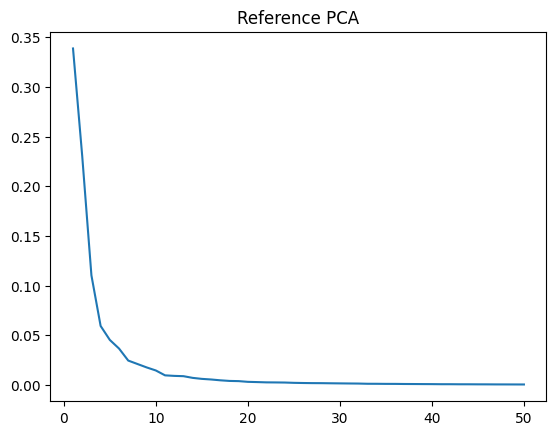

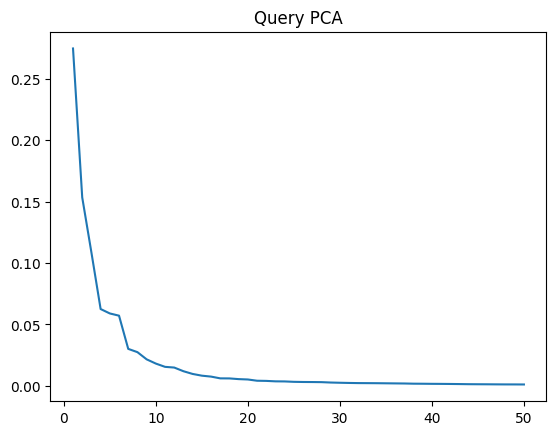

	Finding neighbors...
	Finding Louvain communities...

Step 2: Find closest matching communities

Step 3: Find closest matching reference cells in communities
	Matching query 0 to reference ['0', '12', '23']...
	Matching query 1 to reference ['16', '14']...
	Matching query 2 to reference ['15']...
	Matching query 3 to reference ['11']...
	Matching query 4 to reference ['6', '20']...
	Matching query 5 to reference ['11']...
	Matching query 6 to reference ['10']...
	Matching query 7 to reference ['7', '9']...
	Matching query 8 to reference ['7']...
	Matching query 9 to reference ['5', '8']...
	Matching query 10 to reference ['0']...
	Matching query 11 to reference ['10']...
	Matching query 12 to reference ['4', '19']...
	Matching query 13 to reference ['22']...
	Matching query 14 to reference ['15']...
	Matching query 15 to reference ['2', '4', '17']...
	Matching query 16 to reference ['1', '3', '21']...
	Matching query 17 to reference ['1']...
	Matching query 18 to reference ['18']...
	

In [15]:
var_series = pd.Series(\
    que_adata.var.index.values, 
    index=que_adata.var.index.values)

preds = cellharmony(\
    reference_adata=ref_adata, 
    query_adata=que_adata, 
    obs_field="ari_group", 
    var_series=var_series,
    reference_npcs=30, 
    query_npcs=30,
    reference_louvain_resolution=1, 
    query_louvain_resolution=1,
    use_zscore=True)

In [16]:
adjusted_rand_score(que_adata.obs["ari_group"].values, preds["top_match"].values)

0.519126342215925